In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
import xarray as xr

In [7]:
NE_prices = pd.read_csv('E:\\OtherCodeProjects\\Springboard Capstone Projects\\Springboard-Capstone-2-Data\\Niger_food_prices.csv')
NE_prices['date'] = pd.to_datetime(NE_prices['date'])
NE_prices.head()

,date,days,Maize - Retail,Rice (imported) - Retail,Sorghum - Retail,Millet - Retail,Beans (niebe) - Retail
0,1990-01-01,7305.0,58.25,201.666667,57.750000,61.00,NaN
1,1990-02-01,7336.0,58.25,201.666667,54.250000,63.40,NaN
2,1990-03-01,7364.0,58.25,201.666667,54.750000,65.20,NaN
3,1990-04-01,7395.0,58.25,202.333333,55.500000,69.60,NaN
4,1990-05-01,7425.0,58.25,202.333333,49.666667,63.25,NaN


In [6]:
#train = NE_prices[NE_prices['date'].dt.strftime('%Y') < '2018']
#test = NE_prices[NE_prices['date'].dt.strftime('%Y') >= '2018']

In [8]:
precip_data = Dataset('E:\\OtherCodeProjects\\Springboard Capstone Projects\\Springboard-Capstone-2-Data\\niger_rainfall.nc')

In [10]:
precip_data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.4
    title: CRU TS4.06 Precipitation
    institution: Data held at British Atmospheric Data Centre, RAL, UK.
    source: Run ID = 2204291347. Data generated from:pre.2204291209.dtb
    history: Fri 29 Apr 16:08:23 BST 2022 : User f098 : Program makegridsauto.for called by update.for
    references: Information on the data is available at http://badc.nerc.ac.uk/data/cru/
    comment: Access to these data is available to any registered CEDA user.
    contact: support@ceda.ac.uk
    dimensions(sizes): time(373), lon(32), lat(15)
    variables(dimensions): float32 lon(lon), float32 lat(lat), float32 time(time), float32 pre(time, lat, lon), int32 stn(time, lat, lon)
    groups: 

In [9]:
precip_data.variables.keys()

dict_keys(['lon', 'lat', 'time', 'pre', 'stn'])

In [12]:
for d in precip_data.dimensions.items():
    print(d)

('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 373)
('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 32)
('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 15)


In [11]:
precip = precip_data.variables['pre']
print(precip)

<class 'netCDF4._netCDF4.Variable'>
float32 pre(time, lat, lon)
    _FillValue: 9.96921e+36
    long_name: precipitation
    units: mm/month
    correlation_decay_distance: 450.0
    missing_value: 9.96921e+36
unlimited dimensions: time
current shape = (373, 15, 32)
filling on


In [13]:
rain_avg = np.mean(precip[:,:,:], axis=0)

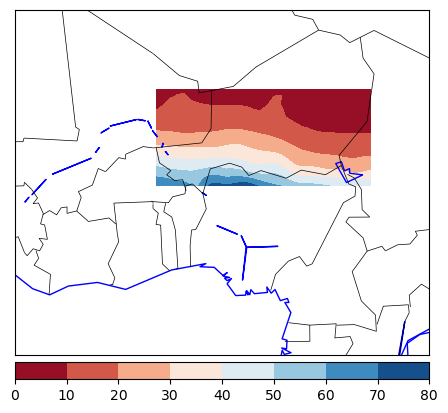

In [15]:
plt.figure()
map = Basemap(projection='cyl', resolution='c', llcrnrlat=0, urcrnrlat=25, llcrnrlon=-10, urcrnrlon=20)
map.drawcoastlines(color='blue')
map.drawcountries()
lons, lats = np.meshgrid(precip_data.variables['lon'][:], precip_data.variables['lat'][:])
x, y = map(lons, lats)
precip_plot = map.contourf(x, y, rain_avg, cmap=plt.cm.RdBu)
cb = map.colorbar(precip_plot, "bottom", size='5%', pad='2%', extend = 'both')
plt.show()

In [16]:
ds = xr.open_dataset('E:\\OtherCodeProjects\\Springboard Capstone Projects\\Springboard-Capstone-2-Data\\niger_rainfall.nc')
rain_df = ds.to_dataframe()
rain_df = rain_df.reset_index()
rain_df.head()

,lon,lat,time,pre,stn
0,0.25,12.25,1989-12-16,1.900000,8.0
1,0.25,12.25,1990-01-16,0.000000,8.0
2,0.25,12.25,1990-02-15,0.000000,8.0
3,0.25,12.25,1990-03-16,0.000000,8.0
4,0.25,12.25,1990-04-16,17.700001,8.0


In [17]:
rain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179040 entries, 0 to 179039
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   lon     179040 non-null  float64       
 1   lat     179040 non-null  float64       
 2   time    179040 non-null  datetime64[ns]
 3   pre     179040 non-null  float32       
 4   stn     179040 non-null  float64       
dtypes: datetime64[ns](1), float32(1), float64(3)
memory usage: 6.1 MB


In [18]:
rain_df.describe()

,lon,lat,pre,stn
count,179040.000000,179040.000000,179040.000000,179040.000000
mean,8.000000,15.750000,23.974272,3.947286
std,4.616559,2.160253,47.822010,3.289880
min,0.250000,12.250000,0.000000,0.000000
25%,4.125000,13.750000,0.000000,0.000000
50%,8.000000,15.750000,0.800000,4.000000
75%,11.875000,17.750000,23.200001,8.000000
max,15.750000,19.250000,390.600006,8.000000
